# Calculate the glass transition temperature, $T_g$, of an amorphous polymer or molecular system using cloud computing at nanoHUB.org

*Benjamin Haley, Lorena Alzate-Vargas, Martin Hunt, Chunyu Li, and Alejandro Strachan* <br>
*Purdue University*

### Main steps to calculate Tg:
1. Build an atomistic model for your molecular material using Polymer Modeler (nanohub.org/tools/polymod)
2. Relax the structure using molecular dynamics (LAMMPS) at a relatively high temperature (above the expected $T_g$)
3. Use molecular dynamics to cool down your system
4. We will identify $T_g$ as a change in slope. Fit the density-temperature data using bilinear and hyperbolic methods and extract $T_g$ 

### Further reading
- *Uncertainties on predictions of thermo-physical properties of thermoplastic polymers via molecular dynamics*, Alzate-Vargas, Lorena; Fortunato, Michael; Haley, Benjamin; Li, Chunyu; Colina, Coray; Strachan, Alejandro, Mod. Sim. Mat. Sci. Eng. (2018).
- *Atomistic simulations of amorphous polymers in the cloud with PolymerModeler*, Haley BP, Li C, Wilson N, Jaramillo E, Strachan A.  arXiv preprint arXiv:1503.03894. 2015 Mar 12.

In [3]:
# System setup
import sys, os, tempfile, numpy as np
import hublib.rappture as rappture
sys.path.append('/apps/share64/debian7/ipynb_tools')
import hubwf

<IPython.core.display.Javascript object>

### Step 1. Build an atomistic model of your polymer or molecular system

In [2]:
# Create an interface to the PolymerModeler tool
task = rappture.Tool('polymod')

This variable selects the source of the monomer molecule(s). By default, we use monomers already defined in the PolymerModeler tool on nanoHUB, but we can also download molecular structure files from ChemSpider.

In [3]:
monomer_source = 'polymod'
#monomer_source = 'chemspider'

In [4]:
# Select the monomer molecule in PolymerModeler
if monomer_source == 'polymod':
    task.set_input('Polymer', 'PMMA (atactic)')

In [ ]:
# Select the monomer molecule from ChemSpider
if monomer_source == 'chemspider':
    chemspider_id = '10571'  # PMMA
    pdbfile = hubwf.get_chemspider_structure(chemspider_id)
    # Use the downloaded monomer molecule with PolymerModeler
    task.set_input('Monomer format', 'pdb')
    with open(pdbfile, 'r') as f:
        pdbstr = f.read()
    task.set_input('Monomer atoms', pdbstr)
    task.set_input('Head atom', 12)
    task.set_input('Tail atom', 8)
    # Visualize the structure
    v = hubwf.view_ball_stick(pdbfile)
    v.add_representation('label', label_type='atomindex')
    display(v)

Run PolymerModeler to pack chains/molecules into a box.  This step builds the initial system and writes the input files for LAMMPS to relax the system (not the $T_g$  calculation)

In [5]:
# Here you need to specify the size of the system and the relaxation parameters for LAMMPS

# Set the length of the chains (monomers per chain)
task.set_input('Monomers per chain', 70)

# Set the number of chains
task.set_input('Number of chains', 10)   

# Use sp3-sp3 torsion energies
task.set_input('Covalent torsion energies', 'sp3-sp3')

# Rotate all torsions along the backbone of chains to pack them as they are built
task.set_input('Torsion selection', 'all')

# Set the build temperature
task.set_input('Monte Carlo temperature', '600K') 

# Have the tool generate input files for LAMMPS
task.set_input('Simulation choice', 'LAMMPS input files only')

# Generate LAMMPS commands to relax the structure
task.set_input('Minimization levels', 3)
task.set_input('Minimization steps', 5000)

# Generate LAMMPS commands to thermalize at 800K

# task.set_input('Ensemble', 'npt')
# that does not work because there are two inputs labelled 'Ensemble'.  We need to use
# specifically set the one we want using the lower-level API.
task['input.phase(simulation_phase).group(lammps_group).group(drivers).choice(ensemble)'] = 'npt'

task.set_input('Number of MD steps', 125000)
task.set_input('Temperature', 800)

# for testing
task['input.phase(structure_phase).group(build_polymer).group(advanced_tab).integer(rng_seed)'] = 42

# Run the tool
task.run(verbose=True)
print 'Finished running PolymerModeler'

/bin/sh -l -c "TOOL_PARAMETERS=/home/nanohub/lalzatev/data/sessions/1364431/2416/driver.hz /apps/polymod/current/middleware/invoke -d /home/nanohub/lalzatev/data/sessions/1364431/2416"
Finished running PolymerModeler


In [6]:
# View the initial structure built by PolymerModeler
task.get_output('Built structures, unwrapped').plot()


NGLWidget()

### Step 2. Relax your system at a high temperature

In [7]:
# Relax and thermalize the initial structure built by PolymerModeler
import hublib.use
%use lammps-15May15

nodes = 4
walltime = '10:00:00'
datafile = 'polymer_relax.data'
with open(datafile, 'w') as f:
    f.write(task.get_output('LAMMPS data file (from builder, before MD)').get_text())
infile = 'lammps_relax.in'
with open(infile, 'w') as f:
    f.write(task.get_output('LAMMPS input file').get_text())

!submit -n $nodes -w $walltime -i $datafile lammps-15May15-parallel -in $infile

Run 6814310 registered 1 job instance. Thu Sep 27 08:49:55 2018
Run 6814310 instance 1 released for submission. Thu Sep 27 08:50:13 2018
(9098753) Job Submitted at ncn@rice Thu Sep 27 08:50:22 2018
(9098753) Simulation Queued at ncn@rice Thu Sep 27 08:50:29 2018
(9098753) Simulation Queued at ncn@rice Thu Sep 27 08:56:50 2018
(9098753) Simulation Queued at ncn@rice Thu Sep 27 09:03:01 2018
(9098753) Simulation Queued at ncn@rice Thu Sep 27 09:09:47 2018
(9098753) Simulation Queued at ncn@rice Thu Sep 27 09:15:12 2018
(9098753) Simulation Queued at ncn@rice Thu Sep 27 09:23:17 2018
(9098753) Simulation Queued at ncn@rice Thu Sep 27 09:28:39 2018
(9098753) Simulation Queued at ncn@rice Thu Sep 27 09:34:01 2018
(9098753) Simulation Queued at ncn@rice Thu Sep 27 09:39:23 2018
(9098753) Simulation Queued at ncn@rice Thu Sep 27 09:44:46 2018
(9098753) Simulation Queued at ncn@rice Thu Sep 27 09:50:08 2018
(9098753) Simulation Queued at ncn@rice Thu Sep 27 09:55:31 2018
(9098753) Simulation Q

(9098753) Simulation Queued at ncn@rice Thu Sep 27 20:02:39 2018
(9098753) Simulation Queued at ncn@rice Thu Sep 27 20:08:01 2018
(9098753) Simulation Queued at ncn@rice Thu Sep 27 20:13:23 2018
(9098753) Simulation Queued at ncn@rice Thu Sep 27 20:18:47 2018
(9098753) Simulation Queued at ncn@rice Thu Sep 27 20:24:08 2018
(9098753) Simulation Queued at ncn@rice Thu Sep 27 20:29:30 2018
(9098753) Simulation Queued at ncn@rice Thu Sep 27 20:34:53 2018
(9098753) Simulation Queued at ncn@rice Thu Sep 27 20:40:15 2018
(9098753) Simulation Queued at ncn@rice Thu Sep 27 20:45:38 2018
(9098753) Simulation Queued at ncn@rice Thu Sep 27 20:51:02 2018
(9098753) Simulation Queued at ncn@rice Thu Sep 27 20:56:24 2018
(9098753) Simulation Queued at ncn@rice Thu Sep 27 21:01:46 2018
(9098753) Simulation Queued at ncn@rice Thu Sep 27 21:07:08 2018
(9098753) Simulation Queued at ncn@rice Thu Sep 27 21:12:30 2018
(9098753) Simulation Queued at ncn@rice Thu Sep 27 21:17:53 2018
(9098753) Simulation Queu

### Step 3. Cool down your system.
- Remember we will extract $T_g$ from the density-temperature data from these simulations
- Cooling rates should be as slow as possible (by MD standards)

In [1]:
# Cool down the structure with LAMMPS
infile = 'lammps_cool.in'
T_steps = 25000
lammps_input = """
read_restart      restart.lammps

neighbor          2.0 bin
thermo_style      custom temp density vol etotal ke pe ebond eangle edihed eimp evdwl ecoul elong press pxx pyy pzz pxy pxz pyz lx ly lz
thermo            100
thermo_modify     flush yes line multi format float %16.6g

timestep          4
neigh_modify      every 1 delay 5
kspace_style      pppm 1e-4
run_style         respa 3 2 2 bond 1 pair 2 kspace 3
velocity          all create 800.0 1214556 mom yes rot yes dist gaussian

# Loop
variable          i loop 71
label             loopa
reset_timestep    0
variable          T equal 800+($i-1)*(-10)

fix               1 all npt temp $T $T 100.0 iso 1.0 1.0 1000.
dump              2 all custom 500 strcool_$TK.dump id type x y z
run               {0}
write_data        str_cool$TK.data
unfix             1
undump            2
next              i
jump              {1} loopa
""".format(T_steps, infile)

with open(infile, 'w' ) as f:
    f.write(lammps_input)
walltime = '50:00:00'

!submit -n $nodes -w $walltime -i restart.lammps lammps-15May15-parallel -in $infile

Run 6848869 registered 1 job instance. Mon Oct 15 11:54:06 2018
Run 6848869 instance 1 released for submission. Mon Oct 15 11:54:33 2018
(2243042) Job Submitted at ncn-hub@brown Mon Oct 15 11:54:42 2018
(2243042) Simulation Queued at ncn-hub@brown Mon Oct 15 11:55:12 2018
(2243042) Simulation Queued at ncn-hub@brown Mon Oct 15 12:01:41 2018
(2243042) Simulation Running at ncn-hub@brown Mon Oct 15 12:05:13 2018
(2243042) Simulation Running at ncn-hub@brown Mon Oct 15 12:11:36 2018
(2243042) Simulation Running at ncn-hub@brown Mon Oct 15 12:17:49 2018
(2243042) Simulation Running at ncn-hub@brown Mon Oct 15 12:24:38 2018
(2243042) Simulation Running at ncn-hub@brown Mon Oct 15 12:30:02 2018
(2243042) Simulation Running at ncn-hub@brown Mon Oct 15 12:38:08 2018
(2243042) Simulation Running at ncn-hub@brown Mon Oct 15 12:43:32 2018
(2243042) Simulation Running at ncn-hub@brown Mon Oct 15 12:48:55 2018
(2243042) Simulation Running at ncn-hub@brown Mon Oct 15 12:54:19 2018
(2243042) Simulati

(2243042) Simulation Running at ncn-hub@brown Mon Oct 15 22:08:12 2018
(2243042) Simulation Running at ncn-hub@brown Mon Oct 15 22:13:34 2018
(2243042) Simulation Running at ncn-hub@brown Mon Oct 15 22:18:58 2018
(2243042) Simulation Running at ncn-hub@brown Mon Oct 15 22:24:20 2018
(2243042) Simulation Running at ncn-hub@brown Mon Oct 15 22:29:42 2018
(2243042) Simulation Running at ncn-hub@brown Mon Oct 15 22:35:06 2018
(2243042) Simulation Running at ncn-hub@brown Mon Oct 15 22:40:29 2018
(2243042) Simulation Running at ncn-hub@brown Mon Oct 15 22:45:51 2018
(2243042) Simulation Running at ncn-hub@brown Mon Oct 15 22:51:13 2018
(2243042) Simulation Running at ncn-hub@brown Mon Oct 15 22:56:35 2018
(2243042) Simulation Running at ncn-hub@brown Mon Oct 15 23:01:57 2018
(2243042) Simulation Running at ncn-hub@brown Mon Oct 15 23:07:19 2018
(2243042) Simulation Running at ncn-hub@brown Mon Oct 15 23:12:42 2018
(2243042) Simulation Running at ncn-hub@brown Mon Oct 15 23:18:06 2018
(22430

(2243042) Simulation Running at ncn-hub@brown Tue Oct 16 08:37:44 2018
(2243042) Simulation Running at ncn-hub@brown Tue Oct 16 08:43:09 2018
(2243042) Simulation Running at ncn-hub@brown Tue Oct 16 08:48:32 2018
(2243042) Simulation Running at ncn-hub@brown Tue Oct 16 08:53:55 2018
(2243042) Simulation Running at ncn-hub@brown Tue Oct 16 08:59:17 2018
(2243042) Simulation Running at ncn-hub@brown Tue Oct 16 09:04:39 2018
(2243042) Simulation Running at ncn-hub@brown Tue Oct 16 09:10:02 2018
(2243042) Simulation Running at ncn-hub@brown Tue Oct 16 09:15:26 2018
(2243042) Simulation Running at ncn-hub@brown Tue Oct 16 09:20:48 2018
(2243042) Simulation Running at ncn-hub@brown Tue Oct 16 09:26:10 2018
(2243042) Simulation Running at ncn-hub@brown Tue Oct 16 09:31:34 2018
(2243042) Simulation Running at ncn-hub@brown Tue Oct 16 09:36:58 2018
(2243042) Simulation Running at ncn-hub@brown Tue Oct 16 09:42:20 2018
(2243042) Simulation Running at ncn-hub@brown Tue Oct 16 09:47:42 2018
(22430

### Step 4. Analyze your MD, extract $T_g$ and plot your data

Tg from bilinear fit: 414 Error: 6.54
Tg from hyperbola fit: 423 Error: 11.82


<IPython.core.display.Javascript object>


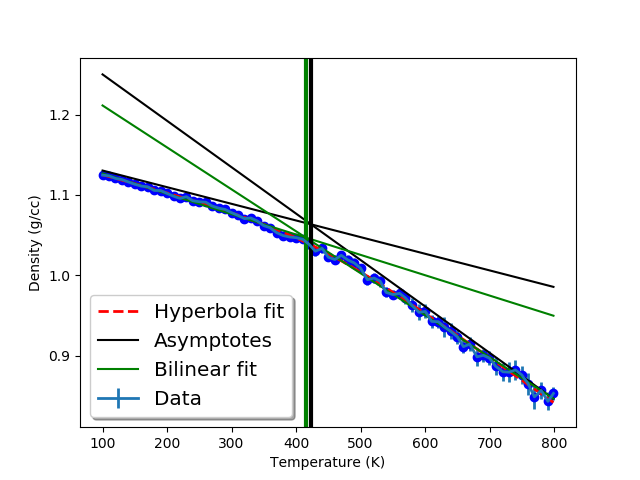

In [4]:
# Extract the density and temperature data from LAMMPS output; find Tg
from Tgcalc import getVDT, getVDTdata, bilinear, hyperbola
%matplotlib notebook
import matplotlib.pyplot as plt

# Calculate Tg
getVDT('log.lammps', T_steps)
T, rho, err = getVDTdata('log.rec_VDT')
prb = bilinear(T,rho,err)
prh = hyperbola(T,rho,err,prb)
print 'Tg from bilinear fit:', int(prb[0]), 'Error:', np.round(prb[5],2)
print 'Tg from hyperbola fit:', int(prh[0]), 'Error:', np.round(prh[1],2)

T, rho, error, fit, alow, ahigh = np.loadtxt('log.rec_VDT.dat', unpack=True)
def fl(T):
    return prb[2]*T+prb[1]
def fh(T):
    return prb[4]*T+prb[3]

# Plot data and results
fig, ax = plt.subplots()
ax.errorbar(T, rho, yerr=error, linewidth=2.0, label='Data')
ax.plot(T, rho, 'bo')
ax.plot(T, fit, 'r--', linewidth=2.0, label='Hyperbola fit')
ax.plot(T, alow, 'k', linewidth=1.5) 
ax.plot(T, ahigh, 'k', linewidth=1.5, label='Asymptotes')
ax.plot(T, fl(T), 'g', linewidth=1.5)
ax.plot(T, fh(T), 'g', linewidth=1.5, label='Bilinear fit')
plt.axvline(x=prb[0], color='g', linewidth=3.0)
plt.axvline(x=prh[0], color='k', linewidth=3.0)
ax.set(xlabel='Temperature (K)', ylabel='Density (g/cc)')
legend = ax.legend(loc='lower left', shadow=True, fontsize='x-large')
plt.show()